# Import and setup

In [1]:
import os
import random
import numpy as np
import torch

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset

# Librerie personalizzate
from dataset import BloodCellDataset
from model import CustomModel
from train import train_one_epoch, validate
from utils import plot_confusion_matrix, plot_normalized_confusion_matrix

# Albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

 # Parameters

In [ ]:
DATASET_PATH = r"C:\Users\Mauro\Desktop\Mauro\Universita\AI\DATASETS\LEUCEMIA\PKG-AML-Cytomorphology_LMU"
VALID_FOLDERS = ["NGS","LYT","MON","MYO"]
IMG_SIZE = 400

TEST_RATIO = 0.1  # 10% test esterno
N_FOLDS = 5
SEED = 42

BATCH_SIZE = 32
EPOCHS = 20
LR = 1e-4
MODEL_NAME = "tf_efficientnetv2_b0"
PRETRAINED = False
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", DEVICE)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

Device: cuda


# Dataset Creation

In [4]:
full_dataset = BloodCellDataset(
    root_dir=DATASET_PATH,
    valid_folders=VALID_FOLDERS,
    img_size=IMG_SIZE,
    transform=None  # No transformations
)

all_labels = np.array(full_dataset.labels) # Return all labels in the dataset
all_indices = np.arange(len(full_dataset)) # Return all the examples in the dataset


# Separazione 10% come final test set

In [5]:
class_to_indices = {} 
for idx, label in enumerate(all_labels):
    class_to_indices.setdefault(label, []).append(idx)

test_indices = []
trainval_indices = []

for label, idx_list in class_to_indices.items():
    idx_arr = np.array(idx_list)
    np.random.shuffle(idx_arr)
    n_test = int(len(idx_arr)*TEST_RATIO)

    test_part = idx_arr[:n_test]
    train_part = idx_arr[n_test:]

    test_indices.extend(test_part)
    trainval_indices.extend(train_part)

test_indices = np.array(test_indices)
trainval_indices = np.array(trainval_indices)

print(f"Test set esterno: {len(test_indices)} esempi")
print(f"Train+Val set (K-fold): {len(trainval_indices)} esempi")

final_test_dataset = Subset(full_dataset, test_indices) # Test set 

Test set esterno: 1745 esempi
Train+Val set (K-fold): 15733 esempi


# K-FOLD

In [6]:
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
labels_for_90 = all_labels[trainval_indices]

# Data augmentation per train
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=180, p=0.5),
    A.RandomBrightnessContrast(p=0.1),
    A.Resize(IMG_SIZE,IMG_SIZE),
    ToTensorV2()
])

# Transform di base per val/test
val_transform = A.Compose([
    A.Resize(IMG_SIZE,IMG_SIZE),
    ToTensorV2()
])

# Per la WeightedRandomSampler, calcoliamo le class weights
# 1 / freq_di_classe = peso. (Es. meno frequente = peso maggiore)
unique_labels, counts = np.unique(labels_for_90, return_counts=True)
class_counts = dict(zip(unique_labels, counts))

# Ad es. weight[class] = 1/count
max_count = max(class_counts.values())
weight_per_class = {}
for c, cnt in class_counts.items():
    weight_per_class[c] = max_count / cnt  # un modo per "bilanciare"

def make_sampler(indices_array):
    # Ritorna un WeightedRandomSampler per oversampling
    # in base a weight_per_class.
    sample_weights = []
    for idx in indices_array:
        label = all_labels[idx]
        sample_weights.append(weight_per_class[label])
    sampler = torch.utils.data.WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(indices_array),  # parità con dimensione set
        replacement=True  # sampling con rimpiazzo
    )
    return sampler

# Funzione per creare un dataset con transform
class SubsetAlbumentations(Dataset):
    def __init__(self, base_dataset, indices, albumentations_transform=None):
        self.base_dataset = base_dataset
        self.indices = indices
        self.transform = albumentations_transform
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, i):
        real_idx = self.indices[i]
        img, label = self.base_dataset[real_idx]
        # Se dataset ritorna un np array HxWxC o un Tensor CxHxW...
        # Adattiamo per Albumentations
        if isinstance(img, torch.Tensor):
            img_np = img.permute(1,2,0).numpy()
        else:
            img_np = img
        if self.transform:
            augmented = self.transform(image=img_np)
            img = augmented["image"]
        return img, label

fold_accuracies = []
fold_number = 1

# K FOLD EXEC

In [7]:
for train_idx, val_idx in skf.split(trainval_indices, labels_for_90):
    print(f"\n=== Fold {fold_number}/{N_FOLDS} ===")
    real_train_indices = trainval_indices[train_idx]
    real_val_indices   = trainval_indices[val_idx]

    print("Train set fold:", len(real_train_indices), "| Val set fold:", len(real_val_indices))

    ds_train = SubsetAlbumentations(full_dataset, real_train_indices, albumentations_transform=train_transform)
    ds_val   = SubsetAlbumentations(full_dataset, real_val_indices, albumentations_transform=val_transform)

    sampler_train = make_sampler(real_train_indices)
    dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, sampler=sampler_train, num_workers=0)
    dl_val   = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    model = CustomModel(
        num_classes=full_dataset.num_classes,
        model_name=MODEL_NAME,
        pretrained=PRETRAINED
    ).to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    best_val_acc = 0.0

    for epoch in range(EPOCHS):
        print(f"  Epoch {epoch+1}/{EPOCHS}")
        train_loss, train_acc = train_one_epoch(model, dl_train, criterion, optimizer, DEVICE)
        val_loss, val_acc, precision, recall, f1, preds, labels = validate(model, dl_val, criterion, DEVICE)

        print(f"    TrainLoss: {train_loss:.4f}  Acc: {train_acc:.4f}"
              f" | ValLoss: {val_loss:.4f}  Acc: {val_acc:.4f}")

        # --- SALVATAGGIO DEL BEST MODEL ---
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"{MODEL_NAME}_best_fold{fold_number}.pth")
            print(f"    ► Salvo best model per fold {fold_number} con val_acc = {best_val_acc:.4f}")

    fold_accuracies.append(best_val_acc)
    print(f"*** Best Val Acc Fold {fold_number}: {best_val_acc:.4f} ***")

    fold_number += 1



=== Fold 1/5 ===
Train set fold: 12586 | Val set fold: 3147
  Epoch 1/20


KeyboardInterrupt: 

# Risultati k-cross

In [7]:
mean_acc = np.mean(fold_accuracies)
std_acc = np.std(fold_accuracies)
print(f"\nRISULTATI CROSS VALIDATION: acc media {mean_acc:.4f} +/- {std_acc:.4f}")


RISULTATI CROSS VALIDATION: acc media 0.9724 +/- 0.0010


# Training su tutto il 90% e test

In [11]:
ds_train_90 = SubsetAlbumentations(full_dataset, trainval_indices, albumentations_transform=train_transform)
sampler_90  = make_sampler(trainval_indices)
dl_train_90 = DataLoader(ds_train_90, batch_size=BATCH_SIZE, sampler=sampler_90, num_workers=0)

ds_test = SubsetAlbumentations(full_dataset, test_indices, albumentations_transform=val_transform)
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)

final_model = CustomModel(num_classes=full_dataset.num_classes, model_name=MODEL_NAME, pretrained=PRETRAINED).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=LR)

In [ ]:
print("\n=== TRAINING FINALE SU TUTTO IL 90% ===")
EPOCHS = 20
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(final_model, dl_train_90, criterion, optimizer, DEVICE)
    print(f"  [FinalTrain] E{epoch+1}/{EPOCHS}  Loss {train_loss:.4f} Acc {train_acc:.4f}")

torch.save(final_model.state_dict(), f"{MODEL_NAME}_final_90perc.pth")
print("► Salvato il modello addestrato su tutto il 90%.")

# Valutazione


=== TEST FINALE (10%) ===
Test Loss 1.3891, Test Acc 0.1868
Precision 0.03, Recall 0.19, F1 0.06


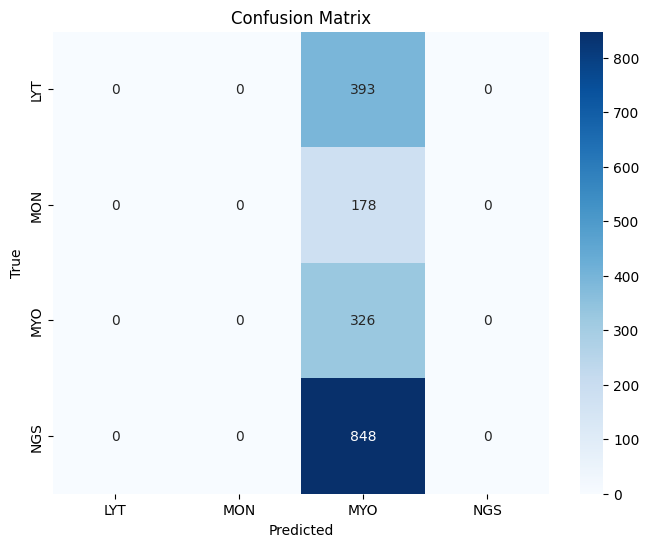

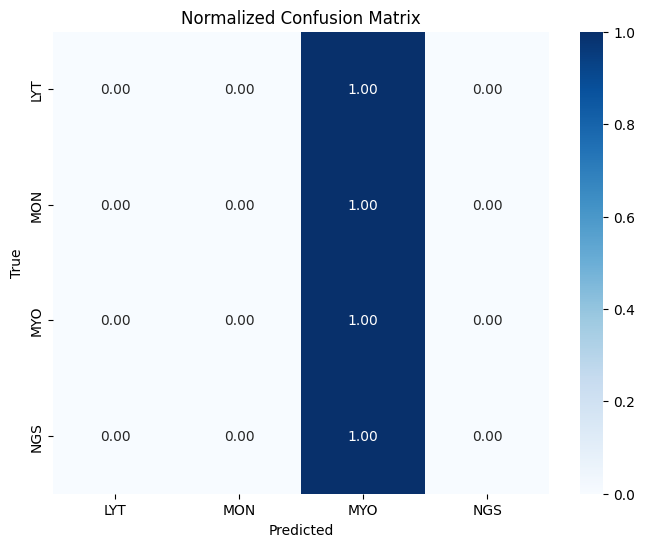

In [12]:
test_loss, test_acc, p, r, f1, preds, labels = validate(final_model, dl_test, criterion, DEVICE)
print("\n=== TEST FINALE (10%) ===")
print(f"Test Loss {test_loss:.4f}, Test Acc {test_acc:.4f}")
print(f"Precision {p:.2f}, Recall {r:.2f}, F1 {f1:.2f}")

plot_confusion_matrix(labels, preds, full_dataset.classes)
plot_normalized_confusion_matrix(labels, preds, full_dataset.classes)

=== EVALUATION DEL MODELLO CARICATO ===
Test Loss 0.0681, Test Acc 0.9794
Precision 0.98, Recall 0.98, F1 0.98


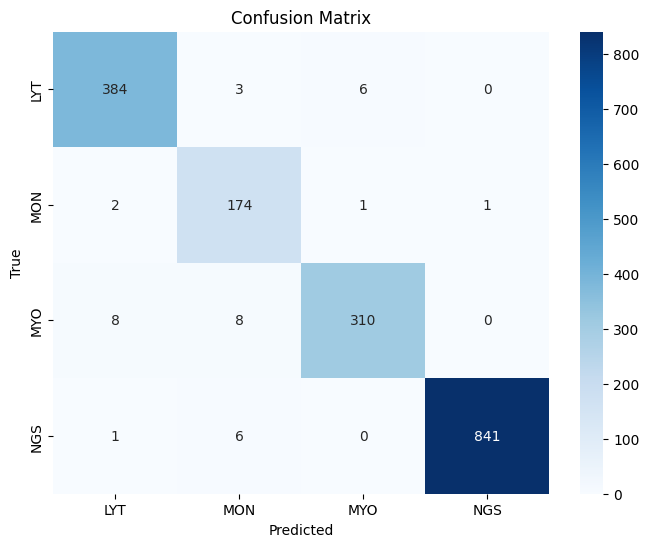

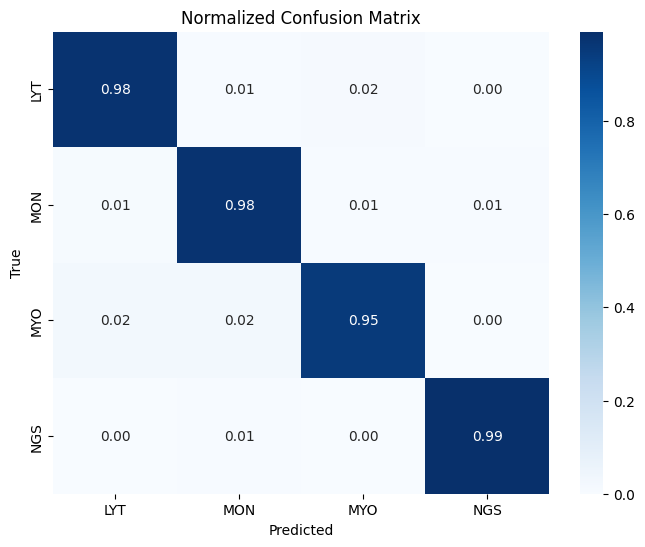

In [14]:
# 1) Crea un’istanza del modello, identico a quello usato in training
loaded_model = CustomModel(
    num_classes=full_dataset.num_classes,
    model_name="efficientnet_b0", 
    pretrained=False
).to(DEVICE)

# 2) Carica i pesi salvati
loaded_model.load_state_dict(torch.load("efficientnet_b0_best_fold1.pth"))

# 3) Metti il modello in eval mode
loaded_model.eval()

# 4) Valuta sul test set
test_loss, test_acc, p, r, f1, preds, labels = validate(
    loaded_model, 
    dl_test,      # il DataLoader del test
    criterion,    # ad esempio nn.CrossEntropyLoss()
    DEVICE
)

print("=== EVALUATION DEL MODELLO CARICATO ===")
print(f"Test Loss {test_loss:.4f}, Test Acc {test_acc:.4f}")
print(f"Precision {p:.2f}, Recall {r:.2f}, F1 {f1:.2f}")

plot_confusion_matrix(labels, preds, full_dataset.classes)
plot_normalized_confusion_matrix(labels, preds, full_dataset.classes)


In [22]:
model_resnet = CustomModel(num_classes=4, model_name="resnet18", pretrained=True)
model_effnet = CustomModel(num_classes=4, model_name="efficientnet_b0", pretrained=True)

# Metodo semplice:
print("=== ResNet18 layers ===")
print(model_resnet)

print("\n=== EfficientNet-B0 layers ===")
print(model_effnet)

# Metodo con torchinfo (se installato):
from torchinfo import summary
summary(model_resnet, input_size=(1, 3, 400, 400))
summary(model_effnet, input_size=(1, 3, 400, 400))


=== ResNet18 layers ===
CustomModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), st

Layer (type:depth-idx)                             Output Shape              Param #
CustomModel                                        [1, 4]                    --
├─EfficientNet: 1-1                                [1, 4]                    --
│    └─Conv2d: 2-1                                 [1, 32, 200, 200]         864
│    └─BatchNormAct2d: 2-2                         [1, 32, 200, 200]         64
│    │    └─Identity: 3-1                          [1, 32, 200, 200]         --
│    │    └─SiLU: 3-2                              [1, 32, 200, 200]         --
│    └─Sequential: 2-3                             [1, 320, 13, 13]          --
│    │    └─Sequential: 3-3                        [1, 16, 200, 200]         1,448
│    │    └─Sequential: 3-4                        [1, 24, 100, 100]         16,714
│    │    └─Sequential: 3-5                        [1, 40, 50, 50]           46,640
│    │    └─Sequential: 3-6                        [1, 80, 25, 25]           242,930
│    │    └─Sequen

# Analisi qualitativa

Classe prevista: 0   Fiducia: 0.9999856948852539


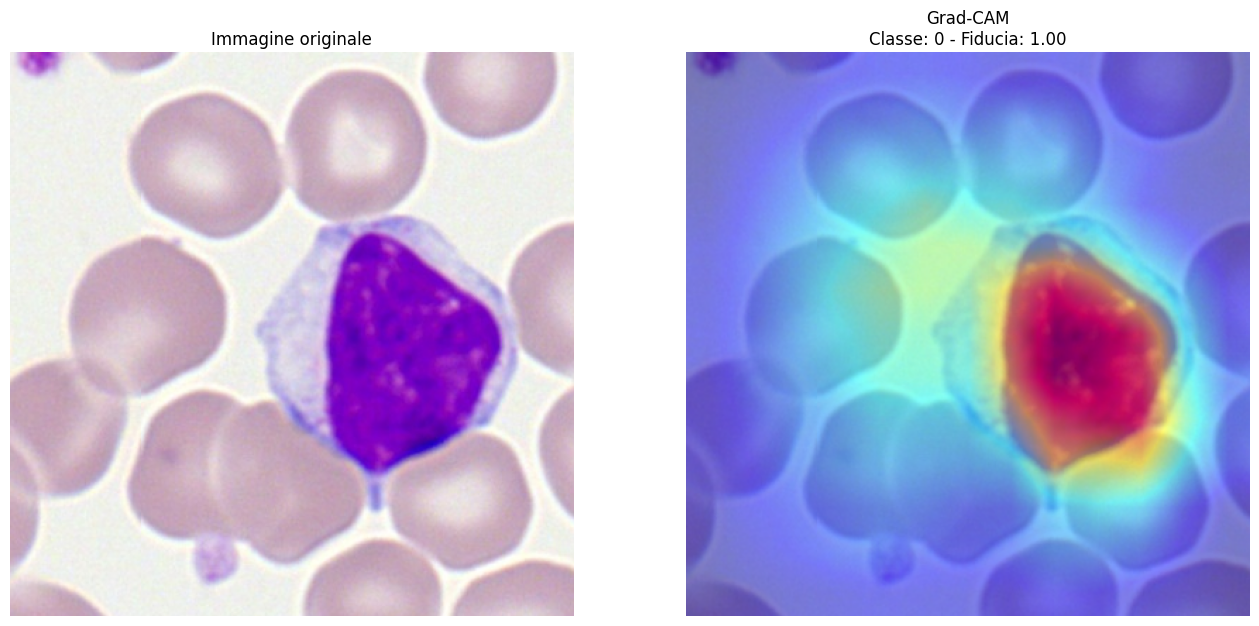

In [37]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import timm
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Configura il dispositivo (GPU se disponibile, altrimenti CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Crea il modello EfficientNet-B0 senza pesi predefiniti
model_effnet = timm.create_model('efficientnet_b0', pretrained=False)

# Resetta il classifier per avere 4 classi
model_effnet.reset_classifier(num_classes=4)

# Carica lo state_dict e rimuovi il prefisso "model." se presente
model_weights_path = r"C:\Users\Mauro\Desktop\Mauro\Universita\AI\Progetto\MindBigData\efficientnet_b0\efficientnet_b0_best_fold5.pth"
state_dict = torch.load(model_weights_path, map_location=device)
new_state_dict = {}
for key, value in state_dict.items():
    new_key = key[len("model."):] if key.startswith("model.") else key
    new_state_dict[new_key] = value

model_effnet.load_state_dict(new_state_dict)
model_effnet = model_effnet.to(device)
model_effnet.eval()

# Scegli il layer target (l'ultimo blocco convoluzionale)
target_layer_effnet = model_effnet.blocks[-1]

# Carica l'immagine di test
img_path = r"C:\Users\Mauro\Desktop\Mauro\Universita\AI\DATASETS\LEUCEMIA\PKG-AML-Cytomorphology_LMU\LYT\LYT_1324.tiff"
img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Carica in BGR
if img is None:
    raise ValueError(f"Impossibile caricare l'immagine da {img_path}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Ridimensiona e normalizza l'immagine
img_resized = cv2.resize(img, (400, 400))
img_normalized = img_resized.astype(np.float32) / 255.0

# Prepara il tensore in formato (1, 3, 400, 400)
input_tensor = torch.from_numpy(img_normalized).permute(2, 0, 1).unsqueeze(0).to(device)

# Esegui la classificazione
with torch.no_grad():
    outputs = model_effnet(input_tensor)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    confidence, predicted_class = torch.max(probabilities, dim=1)

predicted_class = predicted_class.item()
confidence = confidence.item()
print("Classe prevista:", predicted_class, "  Fiducia:", confidence)

# Calcola Grad-CAM
cam_effnet = GradCAM(model=model_effnet, target_layers=[target_layer_effnet])
grayscale_cam = cam_effnet(input_tensor=input_tensor)[0]
cam_image = show_cam_on_image(img_normalized, grayscale_cam, use_rgb=True)

# Visualizza l'immagine originale, la Grad-CAM e la classificazione
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_resized)
plt.title("Immagine originale")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title(f"Grad-CAM\nClasse: {predicted_class} - Fiducia: {confidence:.2f}")
plt.axis("off")

plt.show()

# Misura tempo inferenza

Classe prevista: 0   Fiducia: 0.999925971031189
Tempo di inferenza: 0.0065 secondi


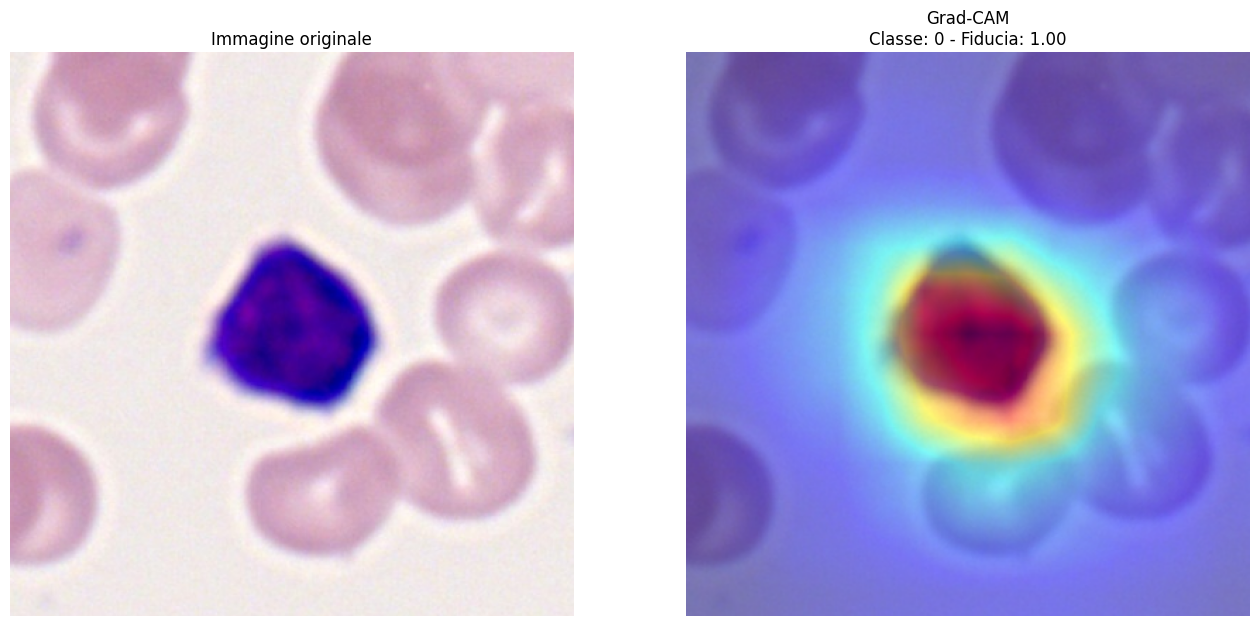

In [80]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import timm
import time
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Configura il dispositivo (GPU se disponibile, altrimenti CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Crea il modello EfficientNet-B0 senza pesi predefiniti
model_effnet = timm.create_model('efficientnet_b0', pretrained=False)

# Resetta il classifier per avere 4 classi
model_effnet.reset_classifier(num_classes=4)

# Carica lo state_dict e rimuovi il prefisso "model." se presente
model_weights_path = r"C:\Users\Mauro\Desktop\Mauro\Universita\AI\Progetto\MindBigData\efficientnet_b0\efficientnet_b0_best_fold5.pth"
state_dict = torch.load(model_weights_path, map_location=device)
new_state_dict = {}
for key, value in state_dict.items():
    new_key = key[len("model."):] if key.startswith("model.") else key
    new_state_dict[new_key] = value

model_effnet.load_state_dict(new_state_dict)
model_effnet = model_effnet.to(device)
model_effnet.eval()

# Scegli il layer target (l'ultimo blocco convoluzionale)
target_layer_effnet = model_effnet.blocks[-1]

# Carica l'immagine di test
img_path = r"C:\Users\Mauro\Desktop\Mauro\Universita\AI\DATASETS\LEUCEMIA\PKG-AML-Cytomorphology_LMU\LYT\LYT_1104.tiff"
img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Carica l'immagine in BGR
if img is None:
    raise ValueError(f"Impossibile caricare l'immagine da {img_path}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Ridimensiona e normalizza l'immagine
img_resized = cv2.resize(img, (400, 400))
img_normalized = img_resized.astype(np.float32) / 255.0

# Prepara il tensore in formato (1, 3, 400, 400)
input_tensor = torch.from_numpy(img_normalized).permute(2, 0, 1).unsqueeze(0).to(device)

# Misura il tempo di inferenza
start_time = time.time()
with torch.no_grad():
    outputs = model_effnet(input_tensor)
end_time = time.time()
inference_time = end_time - start_time

# Calcola le probabilità, la classe e la fiducia
probabilities = torch.nn.functional.softmax(outputs, dim=1)
confidence, predicted_class = torch.max(probabilities, dim=1)
predicted_class = predicted_class.item()
confidence = confidence.item()

print("Classe prevista:", predicted_class, "  Fiducia:", confidence)
print("Tempo di inferenza: {:.4f} secondi".format(inference_time))

# Calcola Grad-CAM
cam_effnet = GradCAM(model=model_effnet, target_layers=[target_layer_effnet])
grayscale_cam = cam_effnet(input_tensor=input_tensor)[0]
cam_image = show_cam_on_image(img_normalized, grayscale_cam, use_rgb=True)

# Visualizza l'immagine originale, la Grad-CAM e la classificazione
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_resized)
plt.title("Immagine originale")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title(f"Grad-CAM\nClasse: {predicted_class} - Fiducia: {confidence:.2f}")
plt.axis("off")

plt.show()